In [1]:
%load_ext autoreload
%autoreload 2
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '9'
from deepsramp import *
import shap

/home/fanrui/miniforge3/envs/sramp/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model = MultiSRAMP().to(device)
model.load_state_dict(torch.load('model/full_400_mature.model', weights_only=True))
model.sramp.oh = None

In [3]:
traindf, testdf = utils.load('data/sramp1/sramp1_mature.data')

In [4]:
trainds = df2ds_multi(traindf)

100%|██████████| 134654/134654 [00:48<00:00, 2794.10it/s]


In [5]:
traindl = ds2dl(trainds, drop_last=False, num_workers=0, batch_size=200)
batch = next(iter(traindl))
x, _ = batch

In [6]:
explainer = shap.GradientExplainer(model, [Onehot(6)(x[0]).to(device), x[1].to(device)])

In [7]:
testds = df2ds_multi(testdf)

100%|██████████| 194716/194716 [01:10<00:00, 2777.82it/s]


In [8]:
model.train()

MultiSRAMP(
  (sramp): SRAMP(
    (oh): None
    (conv_model): Sequential(
      (0): Permute()
      (1): Conv1d(6, 32, kernel_size=(3,), stride=(1,), padding=(1,))
      (2): Conv1d(32, 32, kernel_size=(5,), stride=(1,), padding=(2,))
      (3): Permute()
    )
    (token_emb): Sequential(
      (0): Linear(in_features=6, out_features=20, bias=True)
    )
    (genometrans): Sequential(
      (0): Linear(in_features=12, out_features=12, bias=True)
    )
    (trans): Sequential(
      (0): TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=64, out_features=64, bias=True)
        )
        (linear1): Linear(in_features=64, out_features=256, bias=True)
        (dropout): Dropout(p=0.2, inplace=False)
        (linear2): Linear(in_features=256, out_features=64, bias=True)
        (norm1): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((64,), eps=1e-05, elementwise_affine=True)


In [9]:
testdl = ds2dl(testds, drop_last=False, num_workers=0, batch_size=200)

x0s = []
x1s = []
shap0s = []
shap1s = []

for idx, (x, _) in enumerate(tqdm(testdl)):
    x0s += [Onehot(6)(x[0])]
    x1s += [x[1]]
    shap_values = explainer.shap_values([Onehot(6)(x[0]).to(device), x[1].to(device)])
    shap0s += [shap_values[0]]
    shap1s += [shap_values[1]]
    if idx > 10:
        break

  3%|▎         | 11/368 [1:57:39<63:38:46, 641.81s/it]


In [11]:
import matplotlib.pyplot as plt

In [ ]:
(lambda x: (x) / (x.max(axis=0) - x.min(axis=0) + 1e-8))

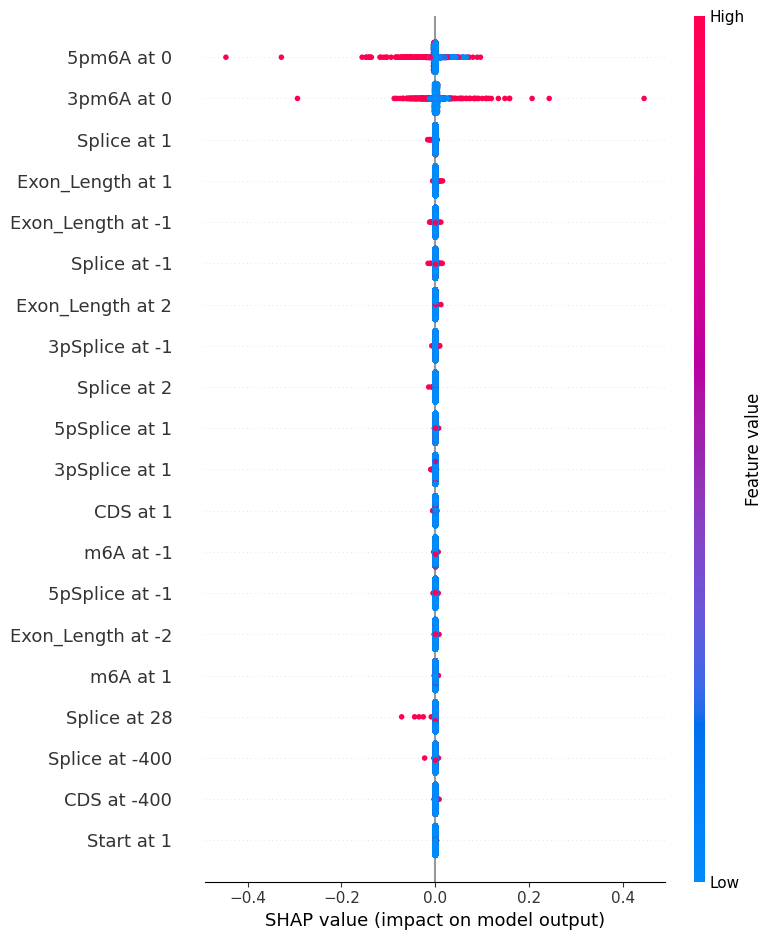

In [24]:
shap.summary_plot((shap1s[0].reshape((-1, 12012))), x1s[0].reshape((-1, 12012)), show=False, 
                  feature_names=[f'{i} at {j-500}' for j in range(1001) for i in ['Position', 'CDS', 'Start', 'Stop', 'Splice', 'Exon_Length', '#Exon', '5pSplice', '3pSplice', '5pm6A', '3pm6A', 'm6A']])
# plt.xscale('symlog')
# plt.xlim(-0.5, 0.5)

In [ ]:
1